## AutoEncoder Modelling

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
import torch.nn.functional as F

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class FaceEmbedder(nn.Module):
#     def __init__(self):
#         super().__init__
        

#### model - 1

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FaceEmbedder(nn.Module):
    def __init__(self,class_num):
        super().__init__()
        # self.encoder = torch.nn.Sequential(
        #     nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, padding='same'),
        #     torch.nn.ReLU(),
            
        #     nn.Conv2d(in_channels=10, out_channels=1, kernel_size=5, padding='same'),
        #     torch.nn.ReLU(),
            
        # )
        # self.decoder = torch.nn.Sequential(
        #     nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, padding='same')
        # )
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3,stride=1) #take embedding here
        self.conv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3,stride=1)
        self.conv5 = nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=3, stride=2)
        self.conv6 = nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=1)
        self.lin1 = nn.Linear(in_features=64*5*5, out_features=class_num)
                                                                                    
    def encode(self, x, w, h):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool1(x) #h,w here?
        embedding = F.interpolate(x, size=(5, 5), mode='bilinear', align_corners=False)
        #here, the dimensionality is 10D, take this tensor for embedding
        
        #resize back to original shape
        # x = F.interpolate(x, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        # x = self.conv2(x)        
        x = F.relu(x)
        # print(x.size())
        # x = F.interpolate(x, size=(30, 30), mode='bilinear', align_corners=False)
        # x = self.decode(x)
        return x, embedding

    def decode(self, x, w, h):
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        
        x = F.interpolate(x, size=(w,h), mode='bilinear', align_corners=False)
        return x #returns reconstructed iamge
    
    def generate_logits(self, embedding):
        predicted_logits = self.lin1(embedding)
        return predicted_logits
    
    def classification_loss(self,logits,labels,class_wts):
        # loss_val = F.cross_entropy(logits,labels)
        loss = nn.CrossEntropyLoss(weight=class_wts)
        loss_val = loss(logits,labels)
        return loss_val

    def forward(self, x, w, h): #to remember input height and width
        x, face_embedding = self.encode(x,w,h)
        x = self.decode(x,w,h)
        face_embedding = F.normalize(face_embedding)
        #classification after flattening embeddings
        face_embeddings = face_embedding.flatten(start_dim=1)
        classifier_logits = self.generate_logits(face_embeddings)
        
        return x,face_embeddings,classifier_logits
    
    # def get_embedding(self,x,embedding):
    #     embedding = 



    def reconstruction_loss(self, x, reconstruction):
        # loss_val = torch.norm(x - reconstruction)
        loss_val = F.mse_loss(reconstruction, x)  
        return loss_val


#### Resnet model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class FaceEmbedder(nn.Module):
    def __init__(self, class_num):
        super().__init__()
        
        resnet = resnet18(pretrained=True)
        # Modify the first convolutional layer to accept 3 input channels instead of 1
        self.resnet_conv = nn.Sequential(*list(resnet.children())[:-2]) #removes the pooling and fully connected layers, to form embedding
        
        # self.pool1 = nn.MaxPool2d(kernel_size=3, stride=1) 
        
        self.conv4 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=1)
        self.conv5 = nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=3, stride=2)
        self.conv6 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=1)
        
        # for classification
        self.lin1 = nn.Linear(in_features=512*3*3, out_features=class_num) 

    def encode(self, x, w, h):
        x = self.resnet_conv(x)
        x = F.relu(x)
        # x = self.pool1(x)  # h, w here?
        embedding = F.interpolate(x, size=(3, 3), mode='bilinear', align_corners=False)
        x = F.relu(x)
        return x, embedding

    def decode(self, x, w, h):
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        
        x = F.interpolate(x, size=(w, h), mode='bilinear', align_corners=False)
        return x  # returns reconstructed image

    def generate_logits(self, embedding):
        embedding_flat = embedding.view(embedding.size(0), -1)
        predicted_logits = self.lin1(embedding_flat)
        return predicted_logits

    def classification_loss(self, logits, labels, class_wts):
        loss = nn.CrossEntropyLoss(weight=class_wts)
        loss_val = loss(logits, labels)
        return loss_val

    def forward(self, x, w, h):  # to remember input height and width
        x, face_embedding = self.encode(x, w, h)
        x = self.decode(x, w, h)
        face_embedding = F.normalize(face_embedding)
        # classification after flattening embeddings
        face_embeddings = face_embedding.flatten(start_dim=1)
        classifier_logits = self.generate_logits(face_embeddings)
        
        return x, face_embeddings, classifier_logits

    def reconstruction_loss(self, x, reconstruction):
        loss_val = F.mse_loss(reconstruction, x)
        return loss_val


#### Visualizing neural network

In [27]:
import torch
from torchviz import make_dot
import torchvision.transforms as transforms

# Assuming FaceEmbedder is defined in the same script
model = FaceEmbedder(class_num=158)  # Adjust class_num as needed

# Dummy input
input_tensor = torch.randn(1, 3, 62, 47)  # Adjust input size as needed

# Get the computational graph
reconstructed, face_embeddings, classifier_logits = model(input_tensor, 62, 47)
graph = make_dot((reconstructed, face_embeddings, classifier_logits), params=dict(model.named_parameters()))

# Save the graph to a file
graph.format = 'png'
graph.render('face_embedder_network')


'face_embedder_network.png'

In [16]:
# if __name__ == "__main__":
#     model = FaceEmbedder(64, 64)  # Assuming the original image size is 64x64
#     input_tensor = torch.randn(1, 3, 64, 64)  # Example input tensor with batch size 1 and 64x64 image
#     loss = model.loss(input_tensor)
#     print(loss)

## AutoEncoder Training with LFW Dataset

In [5]:
import torch.optim as optim
from torchvision import datasets, transforms
import os
from PIL import Image
import shutil

In [8]:
# #creaitng train lfw_dataset and test_lfw dataset
# cur_dir = '/interns/iittcseitr24_10/face_attendance/face_embedding/face_dataset_lfw'
# contents = os.listdir(cur_dir)

# train_size = int(0.8 * len(contents))
# test_size = len(contents) - train_size

# train_contents = contents[:train_size]
# test_contents = contents[train_size:]
# train_lfw = '/interns/iittcseitr24_10/face_attendance/face_embedding/train_lfw'
# test_lfw = '/interns/iittcseitr24_10/face_attendance/face_embedding/test_lfw'
# #create the directories now
# os.makedirs(train_lfw, exist_ok=True)
# os.makedirs(test_lfw, exist_ok=True)

# #move into new folders
# for dir_name in train_contents:
#     shutil.move(os.path.join(cur_dir,dir_name), os.path.join(train_lfw, dir_name))
    
# for dir_name in test_contents:
#     shutil.move(os.path.join(cur_dir,dir_name), os.path.join(test_lfw, dir_name))

# # print(len(contents))


### Dataset Preparation

#### Using lfw from scikit learn

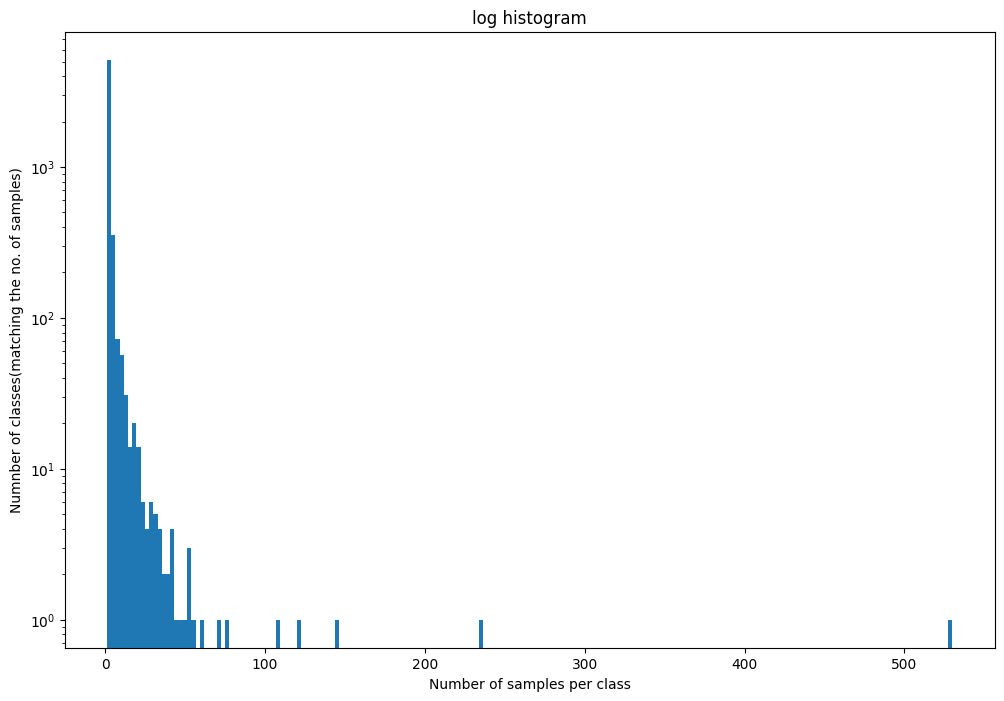

In [6]:
# import numpy as np
# from sklearn.datasets import fetch_lfw_people
# import matplotlib.pyplot as plt
# from collections import Counter

# # Fetch the LFW dataset
# lfw_people = fetch_lfw_people(min_faces_per_person=1, data_home='/interns/iittcseitr24_10/face_attendance/face_embedding', download_if_missing=False)

# # Count the number of samples for each class
# face_counts = Counter(lfw_people.target)

# # Create a list of the counts, sorted by class label
# counts = [face_counts[i] for i in range(len(lfw_people.target_names))]

# # Plot the histogram with more bins
# plt.figure(figsize=(12, 8))
# plt.hist(counts, bins=200, log=True)  # Increase the number of bins for finer x-axis
# plt.xlabel('Number of samples per class')
# plt.ylabel('Numnber of classes(matching the no. of samples)')
# plt.title('log histogram')
# plt.show()


In [23]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import torchvision.transforms as transforms

class LFWDataset(Dataset):
    def __init__(self, data_home, min_faces_per_person=10, transform=None):
        self.lfw_people = fetch_lfw_people(min_faces_per_person=min_faces_per_person, data_home=data_home, download_if_missing=False, color=True)
        self.images = self.lfw_people.images
        self.labels = self.lfw_people.target
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(label, dtype=torch.long)
        
        return image,label
    
    def add_image(self, im, name): #assign new values to 'target'(label) and images. !!only resized
        
        #update the 'lfw_people' bunch object
        new_data = np.append(self.lfw_people.data,[im.flatten()], axis=0)
        new_images = np.append(self.lfw_people.images,[im], axis=0)
        new_target = np.append(self.lfw_people.target,[max(lfw_dataset.lfw_people.get('target')) + 1])
        new_labels = np.append(self.lfw_people.target_names,[name])
        self.lfw_people.update({'data':new_data , 
                                'images': new_images,
                                'target':  new_target,
                                'target_name': new_labels}) 
        
        # return image, label

# Define a transform
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Converts image to PyTorch tensor and scales to [0, 1]
#     transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizes image to range [-1, 1]
# ])

# Path to your LFW dataset
data_home = '/interns/iittcseitr24_10/face_attendance/face_embedding'

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create an instance of the dataset
lfw_dataset = LFWDataset(data_home=data_home, min_faces_per_person=10, transform=transform)

# Verify the dataset
print(f"Number of samples: {len(lfw_dataset)}")

# Get a sample from the dataset
image, label = lfw_dataset[0]
print(f"Image shape: {image.shape}, Label: {label}")

Number of samples: 4324
Image shape: torch.Size([3, 62, 47]), Label: 54


In [ ]:
# print(f"Number of classes: {len(lfw_dataset.lfw_people.target_names)}")
print((lfw_dataset.lfw_people.get('images')))

In [24]:
#perform head segmentation on the dataset
import head_segmentation.segmentation_pipeline as seg_pipeline
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
segmentation_pipeline = seg_pipeline.HumanHeadSegmentationPipeline(device=device)
num = 1
for idx,img in enumerate(lfw_dataset.images):
    img = (img * 255).astype(np.uint8) #converting into uint8 format
    segmentation_map = segmentation_pipeline.predict(img)
    segmented_region = img * cv2.cvtColor(segmentation_map, cv2.COLOR_GRAY2RGB)
    segmented_region_rgb = cv2.cvtColor(segmented_region, cv2.COLOR_BGR2RGB)
    lfw_dataset.lfw_people.images[idx] = segmented_region_rgb #replacing inital img with head segmented img
    lfw_dataset.lfw_people.data[idx] = segmented_region_rgb.flatten()
    print(num)
    num += 1
   
    

218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467


In [33]:
for idx,img in enumerate(lfw_dataset.images):
    lfw_dataset.images[idx] = img.astype(np.float32)/255.0

In [26]:
import pickle
#save class instance data using pickle

with open('lfw_dataset.pkl', 'wb') as f:
    pickle.dump(lfw_dataset, f)


In [ ]:
import matplotlib.pyplot as plt

for idx,img in enumerate(lfw_dataset.images):
    # img_uint8 = (img * 255).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    

In [27]:
# perform oversampling for class imbalance

#1 . data augmentation using imgaug
import imgaug.augmenters as iaa






In [34]:
from torch.utils.data import Subset

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
# ss.get_n_splits() #arguments - input features, target labels
for train_idx, test_idx in ss.split(np.zeros(len(lfw_dataset.labels)),lfw_dataset.labels):
    train_dataset = Subset(lfw_dataset, train_idx)
    test_dataset = Subset(lfw_dataset, test_idx)



In [35]:
# class weights appraoch for class imbalance

from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import WeightedRandomSampler

#sampler
targets_tensor = torch.tensor(lfw_dataset.labels, device = device)
targets_array = targets_tensor.cpu().numpy()
class_weights = compute_class_weight('balanced', classes = np.unique(targets_array), y=targets_array)
class_weights = torch.tensor(class_weights, dtype=torch.float32, device = device)

## train sampler
train_targets = np.array([lfw_dataset.labels[i] for i in train_idx])
train_sample_weights = np.zeros(len(train_targets))
for idx, label in enumerate(train_targets):
    train_sample_weights[idx] = class_weights[label]

train_sample_weights = torch.from_numpy(train_sample_weights).to(device)
train_sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=len(train_sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler = train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


#### current approach


In [45]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

import numpy as np
import shutil

# remove images with < 10 samples from the face_lfw dataset
cur_dir = '/interns/iittcseitr24_10/face_attendance/face_dataset_lfw'
for root, dirs, files in os.walk(cur_dir):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        if len(os.listdir(dir_path)) < 10:
            # remove
            shutil.rmtree(dir_path)
            # print(f"Removed directory: {dir_path}")


#might have to perform resizing here if input image sizes are unequal !!
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = ImageFolder(root='/interns/iittcseitr24_10/face_attendance/face_dataset_lfw', transform=transform)

#stratified split

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
# ss.get_n_splits() #arguments - input features, target labels
for train_idx, test_idx in ss.split(np.zeros(len(dataset.targets)),dataset.targets):
    train_dataset = Subset(dataset, train_idx)
    test_dataset = Subset(dataset, test_idx)

#sampler
targets_tensor = torch.tensor(dataset.targets, device = device)
targets_array = targets_tensor.cpu().numpy()
class_weights = compute_class_weight('balanced', classes = np.unique(targets_array), y=targets_array)
class_weights = torch.tensor(class_weights, dtype=torch.float32, device = device)

# sample_weights = np.zeros(len(targets_array))
# for idx, label in enumerate(targets_array):
#     sample_weights[idx] = class_weights[label]

# sample_weights = torch.from_numpy(sample_weights).to(device)
# sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

## train sampler
train_targets = np.array([dataset.targets[i] for i in train_idx])
train_sample_weights = np.zeros(len(train_targets))
for idx, label in enumerate(train_targets):
    train_sample_weights[idx] = class_weights[label]

train_sample_weights = torch.from_numpy(train_sample_weights).to(device)
train_sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=len(train_sample_weights), replacement=True)
    
# ##test sampler
# test_targets = np.array([dataset.targets[i] for i in test_idx])
# test_sample_weights = np.zeros(len(test_targets))
# for idx, label in enumerate(test_targets):
#     test_sample_weights[idx] = class_weights[label]

# test_sample_weights = torch.from_numpy(test_sample_weights).to(device)
# test_sampler = WeightedRandomSampler(weights=test_sample_weights, num_samples=len(test_sample_weights), replacement=True)



    
train_loader = DataLoader(train_dataset, batch_size=32, sampler = train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


    
    


In [46]:
print(len(os.listdir('/interns/iittcseitr24_10/face_attendance/face_dataset_lfw')))

158


In [69]:
# normal_loader = DataLoader(dataset, batch_size=32, sampler = sampler)

In [47]:
print(dataset.targets)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,

In [48]:
print(len(test_dataset), len(train_dataset))

865 3459


In [3]:
# import os
# import torch
# import torchvision.transforms as transforms
# from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler
# from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# # Create dataset
# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

# train_dataset = ImageFolder(root='/interns/iittcseitr24_10/face_attendance/face_embedding/train_lfw', transform=transform)

targets_tensor = torch.tensor(train_dataset.dataset.targets)
targets_array = targets_tensor.numpy()
class_weights = compute_class_weight('balanced', classes = np.unique(targets_array), y=targets_array)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

sample_weights = np.zeros(len(targets_array))
for idx, label in enumerate(targets_array):
    sample_weights[idx] = class_weights[label]

sample_weights = torch.from_numpy(sample_weights)
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
# # Perform stratified split
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# train_indices, val_indices = next(skf.split(np.zeros(len(targets)), targets))

# # Create subset for train and validation datasets
# train_subset = Subset(train_dataset, train_indices)
# val_subset = Subset(train_dataset, val_indices)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
# val_loader = DataLoader(val_subset, batch_size=256, shuffle=True)

# print(f"Number of training samples: {len(train_subset)}")
# print(f"Number of validation samples: {len(val_subset)}")


In [15]:
print(len(test_dataset.dataset.classes))

1668


In [49]:
print(f'Total samples: {len(dataset)}')
print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')

Total samples: 4324
Training samples: 3459
Test samples: 865


### testing

In [49]:
import numpy as np
from collections import Counter
from torch.utils.data import Subset
def get_class_distribution(dataset, original_dataset):
    targets = [original_dataset.targets[i] for i in dataset.indices]
    class_counts = Counter(targets)
    return class_counts

# Get class distributions
train_class_distribution = get_class_distribution(train_dataset, dataset)
test_class_distribution = get_class_distribution(test_dataset, dataset)
original_class_distribution = Counter(dataset.targets)

print(f"Original class distribution: {len(original_class_distribution)}")
print(f"Train class distribution: {len(train_class_distribution)}")
print(f"Test class distribution: {len(test_class_distribution)}")

Original class distribution: 1668
Train class distribution: 1668
Test class distribution: 1668


In [43]:
print(len(train_dataset.dataset.classes))

1668


In [38]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

#create dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = ImageFolder(root='/interns/iittcseitr24_10/face_attendance/face_embedding/train_lfw', transform=transform)

# #split into training and testing dataset
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [27]:
files = os.listdir('/interns/iittcseitr24_10/face_attendance/face_embedding/min_2_face_dataset_lfw')
# num_files = 20
print(len(files))
# for file_name in files[:num_files]:
#     src_path = os.path.join('/interns/iittcseitr24_10/face_attendance/face_embedding/train_lfw', file_name)
#     dest_path = os.path.join('/interns/iittcseitr24_10/face_attendance/face_embedding/test_lfw', file_name)
#     shutil.copytree(src_path, dest_path)

1668


In [22]:
test_dataset = ImageFolder(root='/interns/iittcseitr24_10/face_attendance/face_embedding/test_lfw', transform=transform)

test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

In [55]:
print(len(train_subset.dataset.classes))
print(type(train_dataset.class_to_idx))
print(train_dataset.class_to_idx['Aaron_Eckhart'])

4599
<class 'dict'>
2


In [48]:
# Reversing the dictionary to map indices to class names
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# Function to get class name from index
def get_class_name_from_index(index):
    return idx_to_class.get(index, "Unknown")

# Example usage
index_to_find = 1482
class_name = get_class_name_from_index(index_to_find)
print(f"Class name for index {index_to_find}: {class_name}")


Class name for index 1482: George_W_Bush


### Model training

In [36]:
model = FaceEmbedder((len(lfw_dataset.lfw_people.target_names)))
# print(list(model.parameters()))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

/interns/iittcseitr24_10/face_attendance/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/interns/iittcseitr24_10/face_attendance/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
print((len(lfw_dataset.lfw_people.target_names)))

158


In [10]:
# #create dataset

# folder_count = 0
# for folder in os.listdir('/interns/iittcseitr24_10/face_attendance/face_embedding/face_dataset_lfw'):
#     folder_count = folder_count + 1
#     for img in os.listdir(os.path.join('/interns/iittcseitr24_10/face_attendance/face_embedding/face_dataset_lfw',folder)):
#         img_path = f'/interns/iittcseitr24_10/face_attendance/face_embedding/face_dataset_lfw/{folder}/{img}'
#         #now copy this into the other folder
#         shutil.copyfile(img_path, os.path.join('/interns/iittcseitr24_10/face_attendance/face_embedding/training_dataset_lfw', os.path.basename(img_path)))
        
#         #now delete the file in the face dataset
#         os.remove(img_path)


In [11]:
# print(folder_count)

5760


In [7]:
# files = os.listdir('/interns/iittcseitr24_10/face_attendance/face_embedding/face_dataset_lfw')

# print(len(files))

5749


In [54]:
print(train_loader)

In [37]:
num_epochs = 15
for epoch in range(num_epochs):
    # running_loss = 0.0
    i = 0
    for images,labels in train_loader:
        # if image is from an index other than trainset_
    
        w, h = images.size(2), images.size(3)
        optimizer.zero_grad()
        reconstruction,face_embedding,logits = model(images,w,h)
        reconstruction_loss = model.reconstruction_loss(images, reconstruction)
        # reconstruction_loss.backward(retain_graph=True)
        classification_loss = model.classification_loss(logits,labels, class_weights)
        # classification_loss.backward()
        total_loss = reconstruction_loss + classification_loss
        total_loss.backward()
        optimizer.step()
        
        # print("Labels, images", labels, images)
        # running_loss += total_loss.item()
        
        # if(i % 5 == 4):
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 5:.3f}')
        #     running_loss = 0.0
        # i += 1
        
    print(f"Epoch {epoch+1}, Total_Loss: {total_loss.item()}, Reconstruction_Loss: {reconstruction_loss.item()}, Classification_Loss: {classification_loss.item()}")
    # torch.save(model.state_dict(), f'/interns/iittcseitr24_10/face_attendance/face_embedding/ffs_{epoch}.pth')

torch.save(model.state_dict(), '/interns/iittcseitr24_10/face_attendance/face_embedding/helio.pth')

    

KeyboardInterrupt: 

## AutoEncoder Testing

In [ ]:
#performing stratified split



In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [20]:
print(len(lfw_dataset.lfw_people.target_names))

158


In [39]:
model = FaceEmbedder(len(lfw_dataset.lfw_people.target_names))
model.load_state_dict(torch.load('/interns/iittcseitr24_10/face_attendance/face_embedding/uiui.pth', map_location=device))
model.to(device)
model.eval()

/interns/iittcseitr24_10/face_attendance/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/interns/iittcseitr24_10/face_attendance/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaceEmbedder(
  (resnet_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [14]:
# test_loss = 0.0
# total = 0
# correct = 0
# fail = 0
# # print(test_dataset.class_to_idx)
# with torch.no_grad(): 
#     for images, labels in test_loader:
#         w, h = images.size(2), images.size(3)
#         reconstruction, _, logits = model(images,w,h)
#         reconstruction_loss = model.reconstruction_loss(images, reconstruction)
#         # max_val = torch.max(logits)
#         predictions = torch.argmax(logits, dim=1) # MAX predicted logit(probabilities)
#         #check if the max logit is equal to the label
#         # if predictions == labels:
#         #     correct += 1
#         # else:
#         #     fail += 1
        
#         total += labels.size(0)
#         correct += (predictions == labels).sum().item()

#         # print(predictions,labels)
#         # test_loss += loss.item()

# #print out the accuracy %
# accuracy = (correct/total) * 100
# print(accuracy)
# # test_loss /= len(train_loader)
# # print(f"Test Loss: {test_loss}")


43.36513443191674


In [55]:
print(len(train_dataset))

7271


In [40]:
test_loss = 0.0
total = 0
correct = 0
fail = 0

with torch.no_grad(): 
    for images, labels in test_loader:
        w, h = images.size(2), images.size(3)
        _, _, logits = model(images,w,h)
        # reconstruction_loss = model.reconstruction_loss(images, reconstruction)
        #convert logits to probabilities - softmax
        
        probabilities = F.softmax(logits, dim=1)
        max_val = torch.max(probabilities, dim=1)
        predictions = torch.argmax(probabilities, dim=1) # MAX predicted logit(probabilities)
        #check if the max logit is equal to the label
        # if predictions == labels:
        #     correct += 1
        # else:
        #     fail += 1
        
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

        
        # test_loss += loss.item()

#print out the accuracy %
accuracy = (correct/total) * 100
print(accuracy)
# test_loss /= len(train_loader)
# print(f"Test Loss: {test_loss}")

12.023121387283236


## Embedding Experiments

In [73]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((250, 250)),
])
# img_path = '/interns/iittcseitr24_10/face_attendance/Al_Gore_1.jpg'
# img_path_1 = '/interns/iittcseitr24_10/face_attendance/group2face/segmented_heads/2.jpg'
# img = Image.open(img_path)
# img_1 = Image.open(img_path_1)
# img_tensor = transform(img).unsqueeze(0)
# img_tensor_1 = transform(img_1).unsqueeze(0)  

In [74]:
img_path = '/interns/iittcseitr24_10/face_attendance/face_embedding/head_segmented_testing_ims/nikhil_0.jpg'
img = Image.open(img_path)
img_tensor = transform(img).unsqueeze(0)
with torch.no_grad():
    reconstruction, f_embed_1 = model(img_tensor)

In [75]:
img_path_1 = '/interns/iittcseitr24_10/face_attendance/face_embedding/head_segmented_testing_ims/nikhil_1.jpg'
img_1 = Image.open(img_path_1)
img_tensor_1 = transform(img_1).unsqueeze(0)  
with torch.no_grad():
    reconstruction, f_embed_2 = model(img_tensor_1)

In [76]:
img_path_2 = '/interns/iittcseitr24_10/face_attendance/face_embedding/head_segmented_testing_ims/pranav_0.jpg'
img_2 = Image.open(img_path_2)
img_tensor_2 = transform(img_2).unsqueeze(0)  
with torch.no_grad():
    reconstruction, f_embed_3 = model(img_tensor_2)

In [77]:
img_path_3 = '/interns/iittcseitr24_10/face_attendance/face_embedding/head_segmented_testing_ims/pranav_1.jpg'
img_3 = Image.open(img_path_3)
img_tensor_3 = transform(img_3).unsqueeze(0)  
with torch.no_grad():
    reconstruction, f_embed_4 = model(img_tensor_3)

In [78]:
img_path_4 = '/interns/iittcseitr24_10/face_attendance/face_embedding/head_segmented_testing_ims/nikhil_2.jpg'
img_4 = Image.open(img_path_4)
img_tensor_4 = transform(img_4).unsqueeze(0)  
with torch.no_grad():
    reconstruction, f_embed_5 = model(img_tensor_4)

In [79]:
#flatten the embedding
vec1 = f_embed_1.flatten(start_dim=1)
vec2 = f_embed_2.flatten(start_dim=1)
vec3 = f_embed_3.flatten(start_dim=1)
vec4 = f_embed_4.flatten(start_dim=1)
vec5 = f_embed_5.flatten(start_dim=1)


# #comparing embeddings of 2 faces of same person-
# print(vec1) #al gore
# print(vec2) #2.jpeg


In [88]:
#measuring embedding similarity (interns) using 'cosine similarity'
print(F.cosine_similarity(vec1,vec2))

tensor([0.9759])


In [96]:
#measuring embedding similarity (interns) using 'euclidean distance'

euclidean_distance = torch.dist(vec3, vec4)
print("euclidean Distance:", euclidean_distance.item())

euclidean Distance: 0.5917515754699707


In [15]:
# #tranform output tensor into embedding

# reconstruction.size()

# flattened = reconstruction.view(reconstruction.size(0), -1)

# print(flattened.size())

torch.Size([1, 187500])


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 

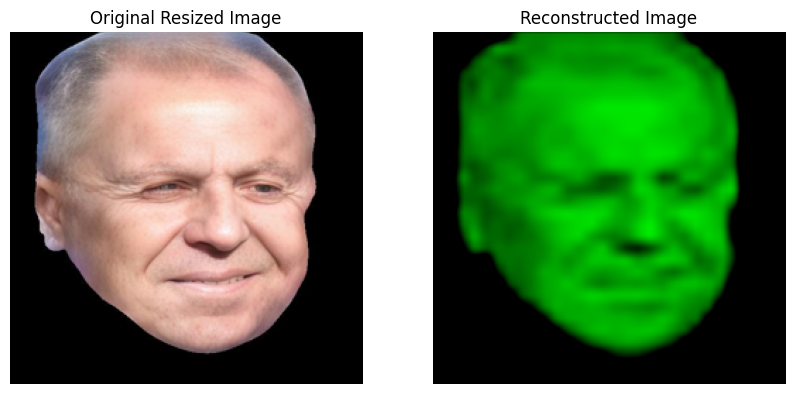

In [10]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Function to convert tensor to PIL image
# def tensor_to_pil_image(tensor):
#     if tensor.dim() == 4:
#         tensor = tensor.squeeze(0)  # Remove batch dimension
#     print(tensor)
#     tensor = tensor.permute(1, 2, 0)  # Change from [C, H, W] to [H, W, C]
#     array = tensor.detach().cpu().numpy()
#     array = (array * 255).astype(np.uint8)  # Assuming the tensor is normalized to [0, 1]
#     image = Image.fromarray(array)
#     return image

# # Convert the tensor to a PIL image for visualization
# print(reconstruction)
# reconstructed_img = tensor_to_pil_image(reconstruction)

# # Display the original and reconstructed images
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title('Original Resized Image')
# plt.imshow(img.resize((250,250)))
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title('Reconstructed Image')
# plt.imshow(reconstructed_img)
# plt.axis('off')

# plt.show()

In [ ]:
# num_epochs = 5